In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import roc_curve, auc

import os
import sys

In [ ]:
DATA_PATH = '../../IFT6758_Data/'
PROJECT_PATH = '../../Milestone2/'


sys.path.append(PROJECT_PATH)
from features.tidy_data import tidy_data


In [52]:
from visualizations.simple_visualization import *

In [ ]:
from features.feature_eng1 import *

In [75]:
# Read in data and assign X and y
data = pd.read_csv('IFT6758B-Project-B10/Milestone2/features/train_data.csv', index_col=0)
data
X = data[['shot_distance', 'shot_angle' ]]
X = X.rename({'shot_distance': 'distanceFromNet', 'shot_angle': 'angleFromNet'}, axis=1)
X.interpolate(method='linear', inplace=True)
X

,distanceFromNet,angleFromNet
0,57.775427,23.459024
1,26.000000,0.000000
2,10.000000,0.000000
3,25.612497,38.659808
4,28.635642,24.775141
...,...,...
253470,12.529964,61.389540
253471,18.867962,32.005383
253472,18.027756,33.690068
253473,104.120123,16.172159


In [73]:
# Check for NaN values in the entire DataFrame 'X'
has_nan = X.isna().any().any()

if has_nan:
    print("There are NaN values in the DataFrame 'X'.")
    X.interpolate(method='linear', inplace=True)
else:
    print("There are no NaN values in the DataFrame 'X'.")

There are no NaN values in the DataFrame 'X'.


In [68]:
y = data[['is_goal']]
y

,is_goal
0,0
1,1
2,0
3,0
4,0
...,...
253470,1
253471,0
253472,0
253473,1


In [60]:
def Log_reg(X, y, feature_list):
    '''
    Arguments:
    X = pd.dataframe X
    y = target labels
    feature_list = list of features
    '''
    #print(X[feature_list])
    X_train,X_val,y_train,y_val = train_test_split(X[feature_list], y, test_size=0.2, random_state=42)

    # Logistic regression model fitting
    clf = LogisticRegression()
    y_train = y_train.values.ravel()
    clf.fit(X_train, y_train)

    # Predict on validation set
    y_pred = clf.predict(X_val)
    accuracy = metrics.accuracy_score(y_val, y_pred)
    #print(f'Accuracy score is {accuracy}')

    #X_test_pred_proba = clf.predict_proba(X_test)
    pred_probs = clf.predict_proba(X_val)

    return X_val, y_val, y_pred, accuracy,  pred_probs

In [61]:
def plot_ROC(y_val,probs,title = False, savename=False):
    """
    Plots an ROC curve for the given y (ground truth) and model probabilities, and calculates the AUC.
    """
    probs_isgoal = pred_probs[:,1]
    fpr, tpr, _ = roc_curve(y_val,probs_isgoal)
    roc_auc = auc(fpr,tpr)
    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    #Include a random classifier baseline, i.e. each shot has a 50% chance of being a goal
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=16)
    plt.ylabel("True Positive Rate", fontsize=16)
    plt.title(f"{title}")
    plt.legend(loc="lower right")

    ax = plt.gca()
    ax.grid()
    ax.set_facecolor('0.95')
    plt.tight_layout()
    if savename:
        plt.savefig(f'{savename}.png')
    plt.show()
    plt.clf()

In [86]:
def calc_percentile(pred_probs, y_val):

    #Create a df for shot probabilities
    df_probs = pd.DataFrame(pred_probs)
    df_probs = df_probs.rename(columns={0: "Not_Goal_prob", 1: "Goal_prob"})

    # Combining 'Goal Probability' and 'Is Goal' into one df.
    df_probs = pd.concat([df_probs["Goal_prob"].reset_index(drop=True), y_val["is_goal"].reset_index(drop=True)],axis=1)

    # Computing and adding Percentile Column
    percentile_values=df_probs['Goal_prob'].rank(pct=True)
    df_probs['Percentile'] = percentile_values*100
    df_percentile = df_probs.copy()

    return df_percentile

In [81]:
def goal_rate(df_percentile):

    rate_list = []

    # Find total number of goals
    total_goals = df_percentile['is_goal'].value_counts()[1]


    bin_width = 5

    i = 0
    i_list = []


    while i< (100-bin_width+1):  # 95 is the lower bound of last bin
        i_list.append(i)

        # i-th bin size
        bin_lower_bound = i
        bin_upper_bound = i + bin_width

        # finding rows have percentiles fall in this range
        bin_rows = df_percentile[(df_percentile['Percentile']>=bin_lower_bound) & (df_percentile['Percentile']<bin_upper_bound)]

        # Calculating the goal rate from total number of goals and shots in each bin_rows
        goals = bin_rows['is_goal'].value_counts()[1]
        shots = len(bin_rows) #total shots in bin_rows
        rate = (goals/shots)*100 # goal rate in pecerntage

        rate_list.append(rate)

        i+=bin_width

    # Creating a new dataframe Combining goal rate list and percentile list
    goal_rate_df = pd.DataFrame(list(zip(rate_list, i_list)),columns=['Rate', 'Percentile'])

    return goal_rate_df

In [63]:
def plot_goal_rates(goal_rate_df):
    ax = plt.gca()
    ax.grid()

    ax.set_facecolor('0.95')
    x = goal_rate_df['Percentile']
    y = goal_rate_df['Rate']
    plt.plot(x,y)

    ax.set_ylim([0,100])
    ax.set_xlim([0,100])
    ax.invert_xaxis()
    major_ticks = np.arange(0, 110, 10)
    ax.set_xticks(major_ticks)
    ax.set_yticks(major_ticks)

    ax.legend(['Model 1'])

    plt.xlabel('Shot probability model percentile', fontsize=16)
    plt.title('Goal Rate')
    plt.ylabel('Goals / (Shots+Goals)%', fontsize=16)
    plt.show()

In [84]:
def plot_cumulative_goal_rates(df_percentile):
    df_precentile_only_goal = df_percentile[df_percentile['is_goal'] == 1]

    ax = sns.ecdfplot(data=df_precentile_only_goal, x=100 - df_precentile_only_goal.Percentile)

    ax = plt.gca()
    ax.grid()
    ax.set_facecolor('0.95')
    plt.yticks(np.arange(0, 1.05, 0.1))
    plt.xticks(np.arange(0, 100 * 1.01, 10))
    xvals = ax.get_xticks()
    ax.set_xticklabels(100 - xvals.astype(np.int32), fontsize=12)
    yvals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0%}'.format(y) for y in yvals], fontsize=12)
    ax.set_xlabel('Shot probability model percentile', fontsize=16)
    ax.set_ylabel('Proportion', fontsize=16)
    ax.set_title(f"Cumulative % of Goals")
    #plt.legend(loc='lower right')
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    ax.legend(['Model 1'])

    plt.show()

In [83]:
def plot_calibration_curve_prediction(y_val, pred_probs):

    ax = CalibrationDisplay.from_predictions(y_val['is_goal'],pred_probs[:,1], n_bins=50)

    ax = plt.gca()
    ax.grid()
    ax.set_facecolor('0.95')
    plt.ylabel('Fraction of positives', fontsize=16)
    plt.xlabel('Mean predicted probability', fontsize=16)
    plt.show()

Accuracy score is 0.9049807673340566


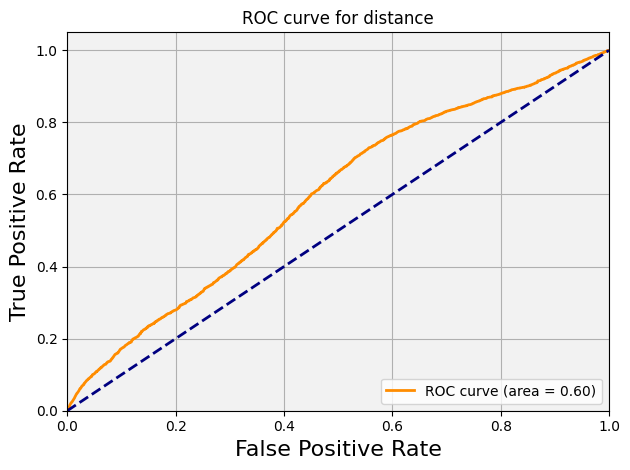

<Figure size 640x480 with 0 Axes>

In [76]:
feature_list = ['distanceFromNet', 'angleFromNet']
#feature_list = ['distanceFromNet']
X_val, y_val, y_pred, accuracy,  pred_probs = Log_reg(X, y, feature_list)
#X_val, y_val, y_pred, accuracy,  pred_probs = Log_reg(X, y, ['angleFromNet'])
print(f'Accuracy score is {accuracy}')
plot_ROC(y_val, pred_probs, 'ROC curve for distance')
#print(pred_probs)
#print(y_val)

In [78]:
# Look at where it's all gone wrong
X_val_compar = X_val.copy()
X_val_compar['preds'] = y_pred
X_val_compar['actual'] = y_val['is_goal']
wrong_preds = X_val_compar[X_val_compar['preds'] != X_val_compar['actual']]
#print(wrong_preds)
wrong_preds.describe()

,distanceFromNet,angleFromNet,preds,actual
count,4817.000000,4817.000000,4817.0,4817.0
mean,87.322051,15.820804,0.0,1.0
std,69.363213,18.895467,0.0,0.0
min,0.000000,0.000000,0.0,1.0
25%,17.029386,1.871745,0.0,1.0
50%,56.435804,7.066730,0.0,1.0
75%,161.111762,25.559965,0.0,1.0
max,187.181730,90.000000,0.0,1.0


In [79]:
pred_probs

array([[0.94416264, 0.05583736],
       [0.94121173, 0.05878827],
       [0.90368731, 0.09631269],
       ...,
       [0.90965419, 0.09034581],
       [0.91667031, 0.08332969],
       [0.90686591, 0.09313409]])

In [87]:
df_percentile =  calc_percentile(pred_probs, y_val)
df_percentile

,Goal_prob,is_goal,Percentile
0,0.055837,0,6.008482
1,0.058788,0,6.938554
2,0.096313,0,68.832232
3,0.085235,0,33.439195
4,0.094922,0,66.135714
...,...,...,...
50690,0.089661,0,48.884505
50691,0.145920,0,94.236118
50692,0.090346,0,51.270342
50693,0.083330,0,28.792780


Accuracy score is 0.9049807673340566


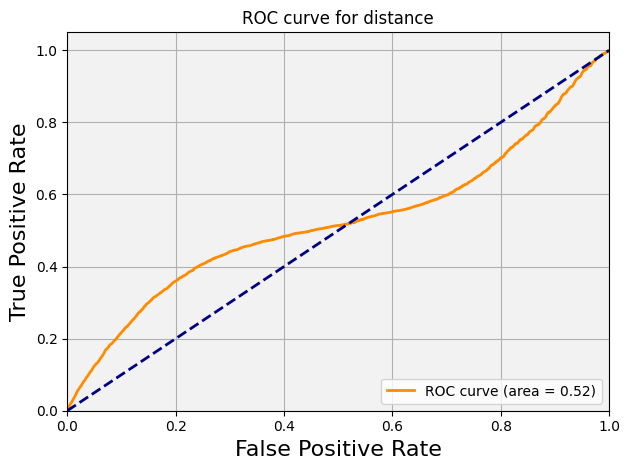

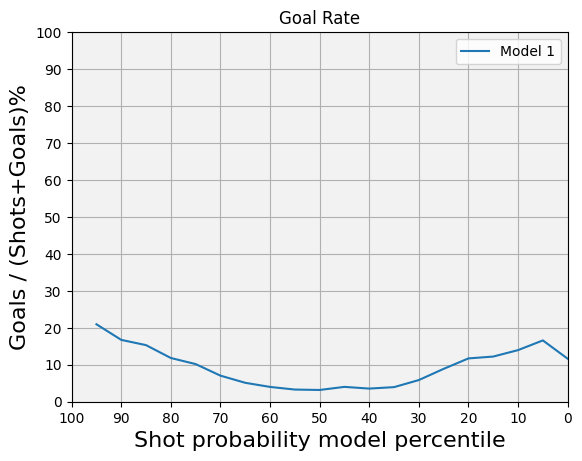

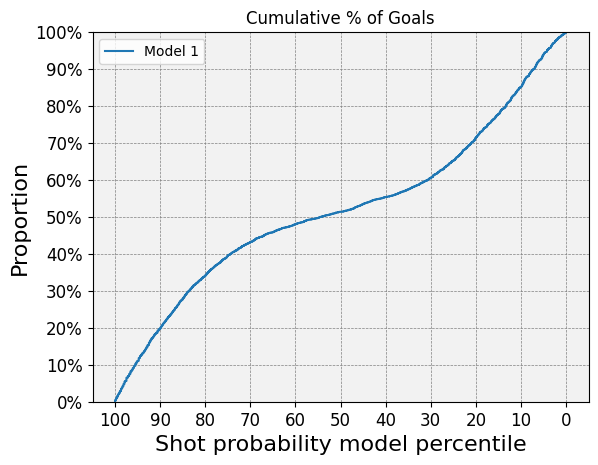

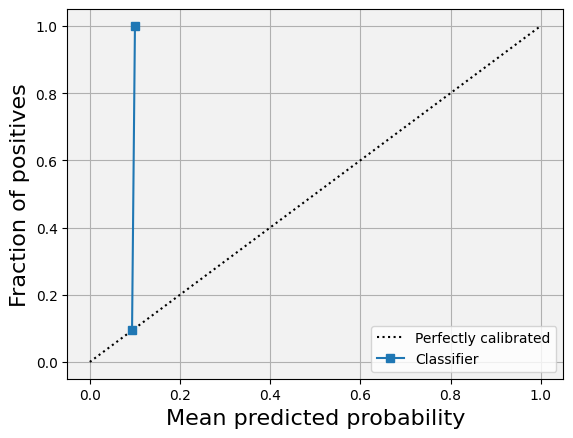

In [88]:
feature_list = ['distanceFromNet', 'angleFromNet']
feature_list = ['distanceFromNet']
X_val, y_val, y_pred, accuracy,  pred_probs = Log_reg(X, y, feature_list)

df_percentile =  calc_percentile(pred_probs, y_val)
goal_rate_df = goal_rate(df_percentile)
print(f'Accuracy score is {accuracy}')

plot_ROC(y_val, pred_probs, 'ROC curve for distance')
plot_goal_rates(goal_rate_df)
plot_cumulative_goal_rates(df_percentile)
plot_calibration_curve_prediction(y_val, pred_probs)

Accuracy score is 0.9049807673340566


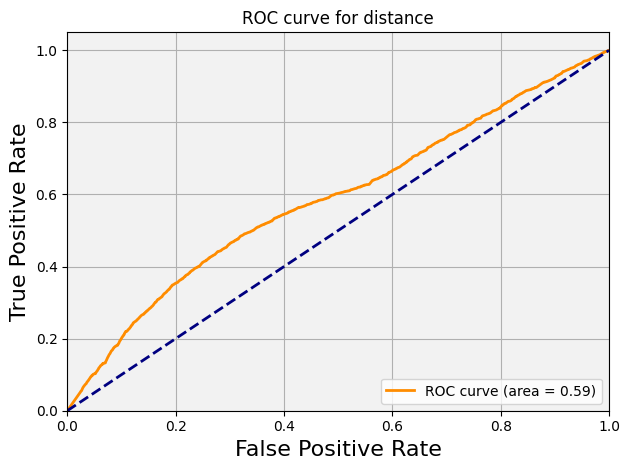

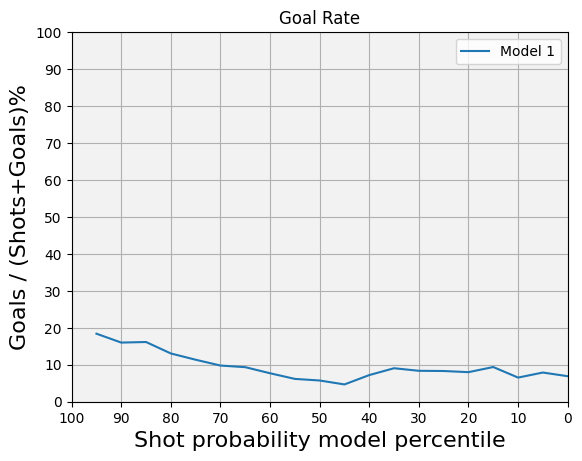

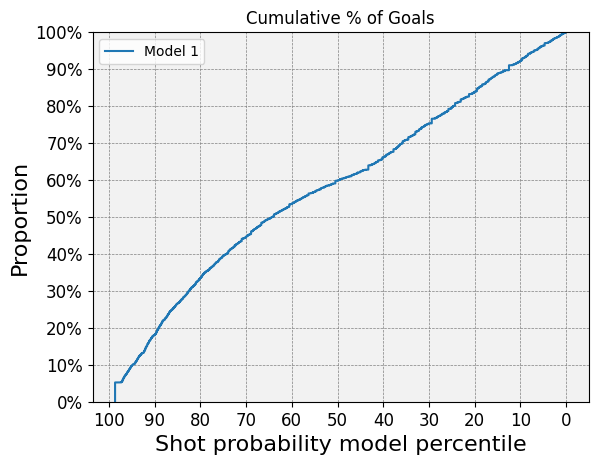

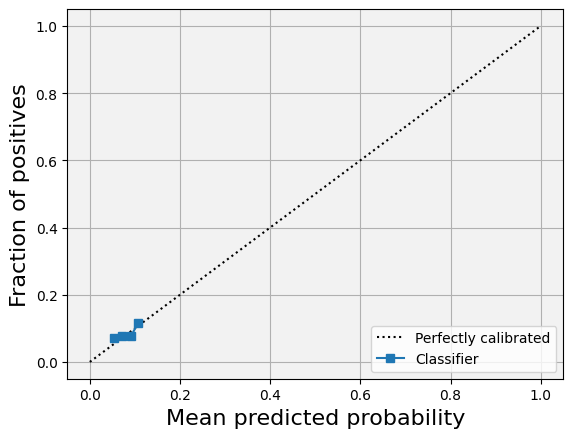

In [89]:
feature_list = ['angleFromNet']
X_val, y_val, y_pred, accuracy,  pred_probs = Log_reg(X, y, feature_list)

df_percentile =  calc_percentile(pred_probs, y_val)
goal_rate_df = goal_rate(df_percentile)
print(f'Accuracy score is {accuracy}')

plot_ROC(y_val, pred_probs, 'ROC curve for distance')
plot_goal_rates(goal_rate_df)
plot_cumulative_goal_rates(df_percentile)
plot_calibration_curve_prediction(y_val, pred_probs)

Accuracy score is 0.9049807673340566


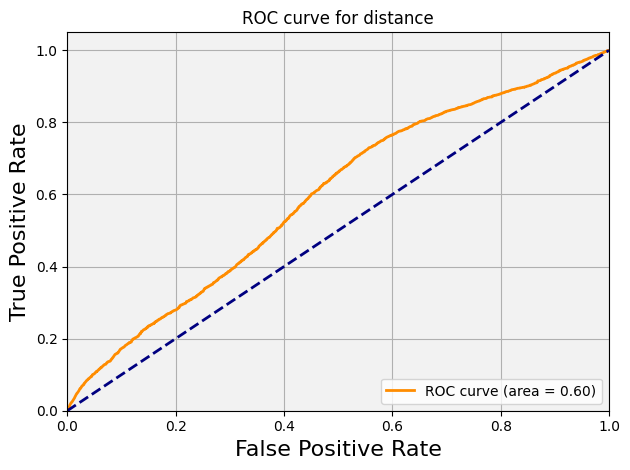

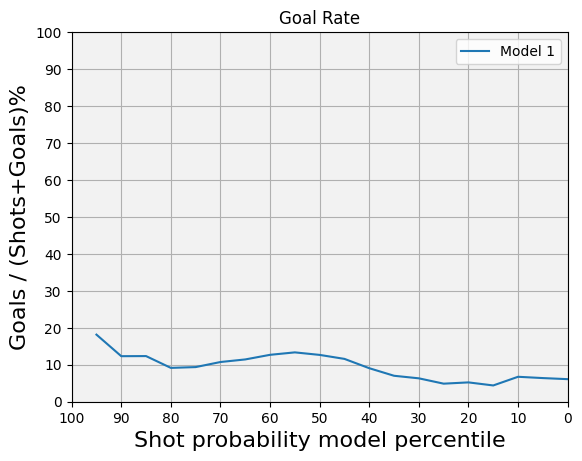

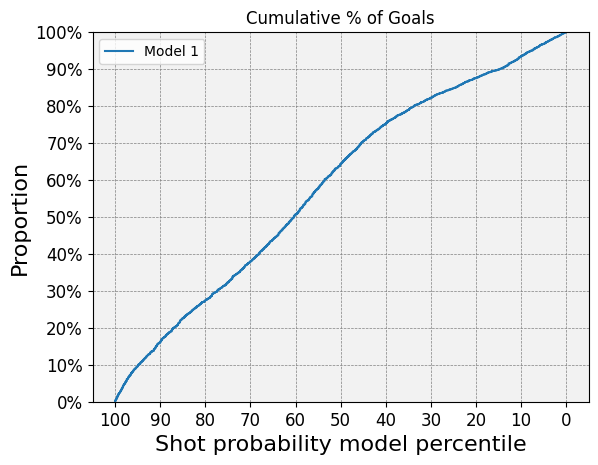

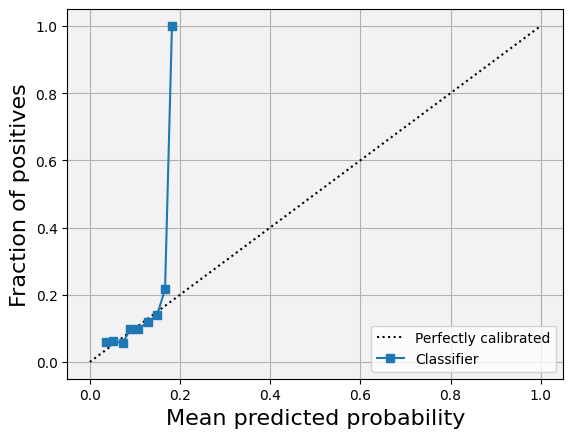

In [90]:
feature_list = ['distanceFromNet', 'angleFromNet']

X_val, y_val, y_pred, accuracy,  pred_probs = Log_reg(X, y, feature_list)

df_percentile =  calc_percentile(pred_probs, y_val)
goal_rate_df = goal_rate(df_percentile)
print(f'Accuracy score is {accuracy}')

plot_ROC(y_val, pred_probs, 'ROC curve for distance')
plot_goal_rates(goal_rate_df)
plot_cumulative_goal_rates(df_percentile)
plot_calibration_curve_prediction(y_val, pred_probs)